In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
app = pd.read_csv("application_record.csv")
crecord = pd.read_csv("credit_record.csv")

# Seperate training and test sets

In [3]:
def get_df(app, crecord):
    
    app.columns = map(str.lower, app.columns)
    crecord.columns = map(str.lower, crecord.columns)
    
    crecordgb = crecord.groupby('id').agg(max).reset_index()
    crecordgb.drop(['months_balance'], axis=1, inplace=True)
    
    app.drop_duplicates('id', keep='last', inplace=True) 
    
    return app.join(crecordgb.set_index('id'), on='id', how='inner')

In [5]:
df = get_df(app,crecord)
df.head()

,id,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,name_income_type,name_education_type,name_family_status,name_housing_type,days_birth,days_employed,flag_mobil,flag_work_phone,flag_phone,flag_email,occupation_type,cnt_fam_members,status
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,X
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,X
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,X
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,X
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,X


In [6]:
from sklearn.model_selection import train_test_split

X = df.iloc[:,:-1]
y = df.iloc[:,-1]

y.replace({'X': 0, 'C' : 0, '0' : 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6}, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
num_attributes = ['cnt_children', 'cnt_fam_members', 'amt_income_total', 'days_birth', 'days_employed']
cat_attributes = ['name_income_type', 'name_education_type', 'occupation_type', 'name_family_status', 'name_housing_type']
bool_attributes = ['code_gender', 'flag_own_car', 'flag_own_realty', 'flag_mobil', 'flag_work_phone', 'flag_phone', 'flag_email']
cat_attributes_full = ['name_income_type','name_education_type','occupation_type','name_family_status','name_housing_type','code_gender','flag_own_car','flag_own_realty','flag_mobil','flag_work_phone','flag_phone','flag_email']

# Preprocessing Pipeline

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

In [10]:
X_train_num = X_train[num_attributes]
X_train_cat = X_train[cat_attributes]

In [11]:
col_dates_names = "days_birth", "days_employed"
birth_ix, employed_ix = [X_train_num.columns.get_loc(c) for c in col_dates_names]

In [12]:
class AddYearsDf(BaseEstimator, TransformerMixin):
    def __init__(self, add_bool = True, unemployed_transf = True):
        self.add_bool = add_bool
        self.unemployed_transf = unemployed_transf
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):  
        years_birth = (-(X.iloc[:, birth_ix]/365)).astype(int)
        years_employed = (-X.iloc[:, employed_ix]/365).astype(int)
        
        if self.unemployed_transf:
            years_employed = np.array(list(map(lambda x: x if x>=0 else 0, years_employed)))
                    
        if self.add_bool:
            employed = (years_employed>0).astype(int)
            return np.c_[X, years_employed, years_birth, employed]
        else:
            return np.c_[X, years_employed, years_birth]
        
    def get_feature_names(self):
        return np.array(list(X.columns)+["years_employed", "years_birth","is_employed"], dtype=object)

In [13]:
num_pipeline = Pipeline([
        ('add_dates', AddYearsDf(add_bool=True, unemployed_transf=True)),
        ('std_scaler', RobustScaler())
    ])

In [14]:
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="most_frequent")), 
    ('one_hot', OneHotEncoder(sparse=False))
])

In [15]:
preprocess_pipeline = ColumnTransformer([
    ('num_to_bool', OrdinalEncoder(), bool_attributes),
    ('num', num_pipeline, num_attributes),
    ('cat', categorical_pipeline, cat_attributes)
])

In [16]:
X_train_prepared = preprocess_pipeline.fit_transform(X_train)

# Test a few models

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [18]:
# using default params 

classifiers = {
    "LogisticRegression" : LogisticRegression(),
    "KNeighbors" : KNeighborsClassifier(),
    "SVC" : SVC(),
    "SVC_rbf" : SVC(kernel='rbf'),
    "DecisionTree" : DecisionTreeClassifier(),
    "RandomForest" : RandomForestClassifier(),
    "XGBoost" : XGBClassifier()
}

In [20]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

cv = RepeatedKFold(n_splits=10, random_state=42, n_repeats=1)

In [34]:
cross_val_score(LogisticRegression(), X_train_prepared, y_train, scoring='balanced_accuracy', cv=cv, n_jobs=-1)

array([0.16666667, 0.16666667, 0.16666667, 0.2       , 0.16666667,
       0.16666667, 0.2       , 0.2       , 0.2       , 0.16666667])

Use balanced accuracy, note that so far the train/test splits are random and that the data is still imbalanced

In [35]:
val_model_mean = {}
val_model_std = {}

for key, classifier in classifiers.items():
    print(f'Evaluating classifier {key}...')
    scores = cross_val_score(classifier, X_train_prepared, y_train, scoring='balanced_accuracy', cv=cv, n_jobs=-1)
    val_model_mean[str(key)] = np.mean(scores)
    val_model_std[str(key)] = np.std(scores)

Evaluating classifier LogisticRegression...
Evaluating classifier KNeighbors...
Evaluating classifier SVC...
Evaluating classifier SVC_rbf...
Evaluating classifier DecisionTree...
Evaluating classifier RandomForest...
Evaluating classifier XGBoost...


In [36]:
# get sorted classifier scores
{k: round(v,4) for k, v in sorted(val_model_mean.items(), key=lambda item: item[1], reverse=True)}

{'RandomForest': 0.2731,
 'DecisionTree': 0.2548,
 'XGBoost': 0.2231,
 'KNeighbors': 0.2196,
 'LogisticRegression': 0.18,
 'SVC': 0.18,
 'SVC_rbf': 0.18}

# Use Random Forest for error analysis

In [61]:
classifier = RandomForestClassifier()
classifier.fit(X_train_prepared, y_train)

RandomForestClassifier()

In [62]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(classifier, X_train_prepared, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)

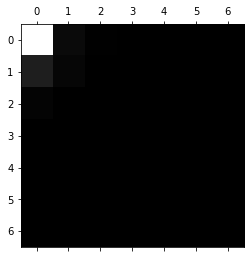

In [63]:
# rows: actual, columns: predicted
plt.matshow(conf_mx, cmap=plt.cm.gray);

0 is predicted accurately, but likely just because most labels are 0

In [64]:
# error rates, take into account number of instances
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

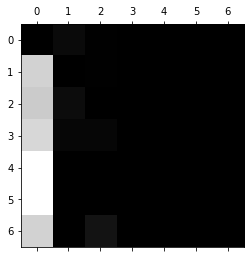

In [65]:
# plot the errors (white=higher number of errors)
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray);

**Most instances are misclassified as 0.**

# Tackle imbalanced data

In [58]:
from collections import Counter

counter = Counter(y_train)
for k,v in counter.items():
    per = v / len(y_train) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=0, n=25113 (86.107%)
Class=1, n=3435 (11.778%)
Class=2, n=530 (1.817%)
Class=6, n=39 (0.134%)
Class=3, n=38 (0.130%)
Class=4, n=7 (0.024%)
Class=5, n=3 (0.010%)


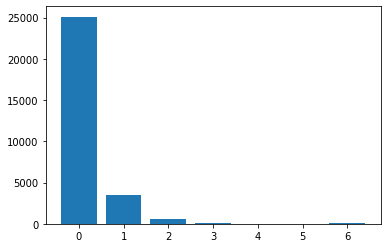

In [59]:
plt.bar(counter.keys(), counter.values());

In [54]:
from imblearn.over_sampling import SMOTE

# note: only apply to training data
oversample = SMOTE(k_neighbors=2)
X_train_bal, y_train_bal = oversample.fit_resample(X_train_prepared, y_train)

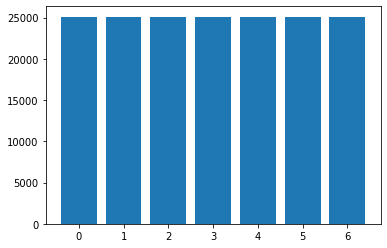

In [60]:
counter = Counter(y_train_bal)
for k,v in counter.items():
    per = v / len(y_train_bal) * 100
    
plt.bar(counter.keys(), counter.values());

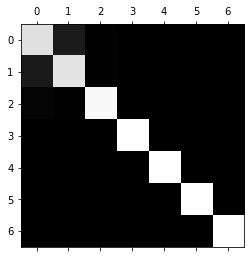

In [66]:
classifier.fit(X_train_bal, y_train_bal)

y_train_pred_bal = cross_val_predict(classifier, X_train_bal, y_train_bal, cv=3)
conf_mx = confusion_matrix(y_train_bal, y_train_pred_bal)

plt.matshow(conf_mx, cmap=plt.cm.gray);

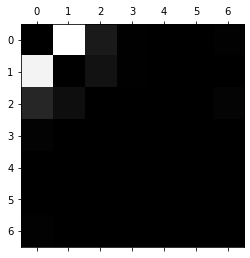

In [67]:
# error rates, take into account number of instances
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray);

Most errors are for 0 falsely classified as 1, and 1 falsely classified as 0

In [69]:
from sklearn.metrics import classification_report

print(classification_report(y_train_bal, y_train_pred_bal))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88     25113
           1       0.88      0.89      0.89     25113
           2       0.98      0.98      0.98     25113
           3       1.00      1.00      1.00     25113
           4       1.00      1.00      1.00     25113
           5       1.00      1.00      1.00     25113
           6       1.00      1.00      1.00     25113

    accuracy                           0.96    175791
   macro avg       0.96      0.96      0.96    175791
weighted avg       0.96      0.96      0.96    175791



In [70]:
# try all default models again on balanced data, 10 CV folds

val_model_mean = {}
val_model_std = {}

for key, classifier in classifiers.items():
    print(f'Evaluating classifier {key}...')
    scores = cross_val_score(classifier, X_train_bal, y_train_bal, scoring='accuracy', cv=cv, n_jobs=-1)
    val_model_mean[str(key)] = np.mean(scores)
    val_model_std[str(key)] = np.std(scores)

Evaluating classifier LogisticRegression...
Evaluating classifier KNeighbors...
Evaluating classifier SVC...
Evaluating classifier SVC_rbf...
Evaluating classifier DecisionTree...
Evaluating classifier RandomForest...
Evaluating classifier XGBoost...


In [71]:
# get sorted classifier scores
{k: round(v,4) for k, v in sorted(val_model_mean.items(), key=lambda item: item[1], reverse=True)}

{'RandomForest': 0.965,
 'DecisionTree': 0.9585,
 'XGBoost': 0.9484,
 'KNeighbors': 0.9359,
 'SVC': 0.6024,
 'SVC_rbf': 0.6024,
 'LogisticRegression': 0.5579}